In [ ]:
!pip install autogluon

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from autogluon.tabular import TabularDataset, TabularPredictor

data = TabularDataset('/content/drive/MyDrive/20250520_140708.csv')

data

Loaded data from: /content/drive/MyDrive/20250520_140708.csv | Columns = 12 / 12 | Rows = 504 -> 504


,Пост мониторинга,Период,NO2,O3,H2S,CO,SO2,"Температура, °С","Давление, мм рт. ст.","Влажность, %","Скорость ветра, м/с","Направление ветра, °"
0,Площадка 21 414,2025-05-13 00:00:00,34.025,14.285,0.381,301.633,0.528,9.110,753.646978,91.050,0.150,182.900
1,Площадка 21 414,2025-05-13 00:20:00,33.280,14.324,0.312,301.328,0.481,9.170,753.639477,91.550,0.166,262.050
2,Площадка 21 414,2025-05-13 00:40:00,32.607,14.292,0.323,304.567,0.456,9.111,753.699482,91.463,0.150,170.158
3,Площадка 21 414,2025-05-13 01:00:00,35.694,15.730,0.420,302.538,0.346,9.015,753.586973,90.660,0.150,259.400
4,Площадка 21 414,2025-05-13 01:20:00,34.151,14.727,0.355,299.873,0.489,8.900,753.556970,90.375,0.177,296.850
...,...,...,...,...,...,...,...,...,...,...,...,...
499,Площадка 21 414,2025-05-19 22:20:00,28.947,4.101,3.618,325.623,0.468,13.710,743.093610,91.570,0.150,103.300
500,Площадка 21 414,2025-05-19 22:40:00,24.948,1.224,6.496,323.505,0.527,13.680,742.966099,91.865,0.150,104.000
501,Площадка 21 414,2025-05-19 23:00:00,26.315,11.714,2.452,321.789,1.733,13.535,742.823588,92.095,0.150,111.750
502,Площадка 21 414,2025-05-19 23:20:00,26.667,14.636,1.097,310.299,0.402,13.500,742.681076,92.360,0.150,131.450


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [ ]:
SEQ_LEN = 96
PRED_LEN = 72

In [ ]:
def load_and_preprocess(path):
    df = pd.read_csv(path, parse_dates=["Период"], dayfirst=True)
    df = df.sort_values("Период")
    df.loc[df["Пост мониторинга"] == "Площадка 21 414", "Пост мониторинга"] = 1
    df["Год"] = df["Период"].dt.year
    df["Месяц"] = df["Период"].dt.month
    df["День"] = df["Период"].dt.day
    df["Час"] = df["Период"].dt.hour
    df["Минута"] = df["Период"].dt.minute
    # Преобразуем "Пост мониторинга" в числовой формат
    df["Пост мониторинга"] = df["Пост мониторинга"].astype("category").cat.codes

    # Удаляем "Период"
    df = df.drop(columns=["Период"])
    df = df.dropna()
    df.columns = [col.strip().replace('"', '').replace(',', '').replace(' ', '_') for col in df.columns]
    return df

In [ ]:
# === 2. Подготовка данных с выделением тестовой выборки ===
def prepare_data(df, seq_len=SEQ_LEN, pred_len=PRED_LEN, test_ratio=0.2):
    target_cols = ['Температура_°С', 'Давление_мм_рт._ст.', 'Влажность_%', 'Скорость_ветра_м/с', 'Направление_ветра_°']

    input_cols = ['Пост_мониторинга', 'Год', 'Месяц', 'День', 'Час', 'Минута']
    features = df[input_cols + target_cols]  # включаем входы + нужные выходы для извлечения

    scaler = StandardScaler()
    data_all = scaler.fit_transform(features)

    input_idx = [features.columns.get_loc(col) for col in input_cols]
    target_idx = [features.columns.get_loc(col) for col in target_cols]

    X, Y = [], []
    for i in range(len(data_all) - seq_len - pred_len):
        X.append(data_all[i:i+seq_len, input_idx])
        Y.append(data_all[i+seq_len:i+seq_len+pred_len, target_idx])

    X = torch.tensor(np.array(X), dtype=torch.float32)
    Y = torch.tensor(np.array(Y), dtype=torch.float32)

    total = len(X)
    split = int(total * (1 - test_ratio))

    X_train, Y_train = X[:split], Y[:split]
    X_test, Y_test = X[split:], Y[split:]

    return X_train, Y_train, X_test, Y_test, scaler, target_cols


In [ ]:
def tensors_to_df(X_tensor, Y_tensor, target_cols):
    X_df = pd.DataFrame(X_tensor.numpy().reshape(X_tensor.shape[0], -1))
    Y_df = pd.DataFrame(Y_tensor[:, -1, :].numpy(), columns=target_cols)  # используем только последний шаг
    return X_df, Y_df


In [ ]:
df = load_and_preprocess('/content/drive/MyDrive/20250520_140708.csv')
X_train, Y_train, X_test, Y_test, scaler, target_cols = prepare_data(df)

<ipython-input-55-6e10432e0778>:2: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df = pd.read_csv(path, parse_dates=["Период"], dayfirst=True)


In [ ]:
X_train_df, Y_train_df = tensors_to_df(X_train, Y_train, target_cols)
X_test_df, Y_test_df = tensors_to_df(X_test, Y_test, target_cols)


In [ ]:
from autogluon.tabular import TabularPredictor

predictors = {}

for target_col in target_cols:
    train_data = X_train_df.copy()
    train_data[target_col] = Y_train_df[target_col]

    print(f"Обучаем модель для: {target_col}")

    predictors[target_col] = TabularPredictor(
        label=target_col,
        problem_type='regression',
        path=f'AutogluonModels/{target_col.replace("/", "_")}'
    ).fit(train_data=train_data, presets='best')


Preset alias specified: 'best' maps to 'best_quality'.
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.0
Python Version:     3.11.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Mar 30 16:01:29 UTC 2025
CPU Count:          2
Memory Avail:       10.12 GB / 12.67 GB (79.9%)
Disk Space Avail:   65.37 GB / 107.72 GB (60.7%)
Presets specified: ['best']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then 

Обучаем модель для: Температура_°С


Leaderboard on holdout data (DyStack):
                     model  score_holdout  score_val              eval_metric  pred_time_test  pred_time_val    fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0        LightGBMXT_BAG_L2      -0.066454  -0.093392  root_mean_squared_error       18.365720       1.888663  737.193403                 0.462228                0.259804          49.963085            2       True         10
1          CatBoost_BAG_L1      -0.067149  -0.076064  root_mean_squared_error        1.133085       0.070300  358.969984                 1.133085                0.070300         358.969984            1       True          6
2     ExtraTreesMSE_BAG_L1      -0.068040  -0.100759  root_mean_squared_error        0.123091       0.480882   10.788909                 0.123091                0.480882          10.788909            1       True          7
3      WeightedEnsemble_L2      -0.069207  -0.074446  root_mean_s

Обучаем модель для: Давление_мм_рт._ст.


Leaderboard on holdout data (DyStack):
                     model  score_holdout  score_val              eval_metric  pred_time_test  pred_time_val    fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0     ExtraTreesMSE_BAG_L2      -0.010655  -0.017913  root_mean_squared_error        2.631480       1.265943  543.782831                 0.109714                0.164643           4.155706            2       True         16
1     ExtraTreesMSE_BAG_L1      -0.012063  -0.015283  root_mean_squared_error        0.108594       0.230150    2.841087                 0.108594                0.230150           2.841087            1       True          7
2      WeightedEnsemble_L3      -0.012289  -0.014987  root_mean_squared_error        0.337356       0.500940   93.361727                 0.003320                0.000616           0.034706            3       True         18
3      WeightedEnsemble_L2      -0.012289  -0.014987  root_mean_s

Обучаем модель для: Влажность_%


Leaderboard on holdout data (DyStack):
                     model  score_holdout  score_val              eval_metric  pred_time_test  pred_time_val    fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0          CatBoost_BAG_L1      -0.047240  -0.072902  root_mean_squared_error        0.709870       0.058056  272.218291                 0.709870                0.058056         272.218291            1       True          6
1      WeightedEnsemble_L2      -0.048500  -0.071328  root_mean_squared_error        9.694221       0.623289  376.837783                 0.003141                0.000647           0.025973            2       True         11
2          CatBoost_BAG_L2      -0.050305  -0.083252  root_mean_squared_error       10.638624       1.572865  629.407462                 0.072237                0.175722         124.576722            2       True         15
3      WeightedEnsemble_L3      -0.050865  -0.070411  root_mean_s

Обучаем модель для: Скорость_ветра_м/с


Leaderboard on holdout data (DyStack):
                        model  score_holdout  score_val              eval_metric  pred_time_test  pred_time_val    fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0       NeuralNetTorch_BAG_L1      -0.210723  -0.465869  root_mean_squared_error        0.114160       0.111051   83.798626                 0.114160                0.111051          83.798626            1       True         10
1        ExtraTreesMSE_BAG_L1      -0.216444  -0.394806  root_mean_squared_error        0.106342       0.249184    2.313958                 0.106342                0.249184           2.313958            1       True          7
2             LightGBM_BAG_L1      -0.216511  -0.413972  root_mean_squared_error        0.052419       0.038394   36.320864                 0.052419                0.038394          36.320864            1       True          4
3           LightGBMXT_BAG_L1      -0.224020  -0.4203

Обучаем модель для: Направление_ветра_°


Leaderboard on holdout data (DyStack):
                     model  score_holdout  score_val              eval_metric  pred_time_test  pred_time_val    fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   NeuralNetFastAI_BAG_L2      -0.316088  -0.320834  root_mean_squared_error        2.052665       1.638671  376.279718                 0.154149                0.377517          68.332218            2       True         19
1           XGBoost_BAG_L2      -0.318856  -0.309282  root_mean_squared_error        2.044435       1.358809  335.779126                 0.145919                0.097655          27.831626            2       True         20
2   RandomForestMSE_BAG_L2      -0.323870  -0.302302  root_mean_squared_error        2.041365       1.448794  312.744391                 0.142849                0.187640           4.796891            2       True         16
3      WeightedEnsemble_L3      -0.325955  -0.282515  root_mean_s

In [ ]:
test_df = pd.concat([X_test_df, Y_test_df], axis=1)

In [ ]:
for target_col in target_cols:
  results = predictors[target_col].evaluate(test_df)
  print(f"{target_col}: {results}")

Температура_°С: {'root_mean_squared_error': np.float32(-0.583886), 'mean_squared_error': -0.34092286229133606, 'mean_absolute_error': -0.41668272018432617, 'r2': 0.24193227291107178, 'pearsonr': 0.8062730431556702, 'median_absolute_error': np.float32(-0.28533787)}
Давление_мм_рт._ст.: {'root_mean_squared_error': np.float32(-1.4582373), 'mean_squared_error': -2.1264560222625732, 'mean_absolute_error': -1.365121841430664, 'r2': -5.99528169631958, 'pearsonr': 0.37414413690567017, 'median_absolute_error': np.float32(-1.4917568)}
Влажность_%: {'root_mean_squared_error': np.float32(-1.0106553), 'mean_squared_error': -1.0214240550994873, 'mean_absolute_error': -0.8760796189308167, 'r2': -1.0944132804870605, 'pearsonr': 0.8012858033180237, 'median_absolute_error': np.float32(-0.8983629)}
Скорость_ветра_м/с: {'root_mean_squared_error': np.float32(-0.61119527), 'mean_squared_error': -0.3735596537590027, 'mean_absolute_error': -0.43435630202293396, 'r2': -0.1854010820388794, 'pearsonr': 0.2246725

In [ ]:
for target_col in target_cols:
  leaderboard = predictors[target_col].leaderboard(test_df, silent=True)
  print(f"{target_col}:{leaderboard}")


Температура_°С:                        model  score_test  score_val              eval_metric  \
0        LightGBMLarge_BAG_L1   -0.482890  -0.110735  root_mean_squared_error   
1             CatBoost_BAG_L2   -0.490179  -0.091029  root_mean_squared_error   
2        CatBoost_r177_BAG_L2   -0.496368  -0.090848  root_mean_squared_error   
3        ExtraTreesMSE_BAG_L1   -0.516047  -0.087886  root_mean_squared_error   
4      RandomForestMSE_BAG_L1   -0.521687  -0.095863  root_mean_squared_error   
5   NeuralNetTorch_r79_BAG_L2   -0.538869  -0.120562  root_mean_squared_error   
6             CatBoost_BAG_L1   -0.560810  -0.074378  root_mean_squared_error   
7              XGBoost_BAG_L2   -0.564104  -0.086194  root_mean_squared_error   
8        ExtraTreesMSE_BAG_L2   -0.571622  -0.078567  root_mean_squared_error   
9         WeightedEnsemble_L2   -0.574041  -0.070747  root_mean_squared_error   
10       CatBoost_r177_BAG_L1   -0.576671  -0.079145  root_mean_squared_error   
11      Neura

In [ ]:

# Пример: выбираем столбец 'NO2' как временной ряд
series = df["Температура, °С"].interpolate().fillna(method="bfill")

<ipython-input-75-04112860c56b>:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series = df["Температура, °С"].interpolate().fillna(method="bfill")


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

class HoltWinters:
    """
    Модель Хольта-Винтерса с методом Брутлага для детектирования аномалий.
    """

    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=2.5):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor

    def initial_trend(self):
        total = 0.0
        for i in range(self.slen):
            total += float(self.series[i + self.slen] - self.series[i]) / self.slen
        return total / self.slen

    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series) / self.slen)
        for j in range(n_seasons):
            season_avg = sum(self.series[self.slen * j:self.slen * j + self.slen]) / float(self.slen)
            season_averages.append(season_avg)
        for i in range(self.slen):
            sum_over_avg = 0.0
            for j in range(n_seasons):
                sum_over_avg += self.series[self.slen * j + i] - season_averages[j]
            seasonals[i] = sum_over_avg / n_seasons
        return seasonals

    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Trend = []
        self.Season = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []

        seasonals = self.initial_seasonal_components()

        for i in range(len(self.series) + self.n_preds):
            if i == 0:
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i % self.slen])
                self.PredictedDeviation.append(0)
                self.UpperBond.append(self.result[0])
                self.LowerBond.append(self.result[0])
                continue

            if i >= len(self.series):
                m = i - len(self.series) + 1
                pred = (smooth + m * trend) + seasonals[i % self.slen]
                self.result.append(pred)
                self.PredictedDeviation.append(self.PredictedDeviation[-1] * 1.01)
            else:
                val = self.series[i]
                last_smooth = smooth
                smooth = self.alpha * (val - seasonals[i % self.slen]) + (1 - self.alpha) * (smooth + trend)
                trend = self.beta * (smooth - last_smooth) + (1 - self.beta) * trend
                seasonals[i % self.slen] = self.gamma * (val - smooth) + (1 - self.gamma) * seasonals[i % self.slen]
                pred = smooth + trend + seasonals[i % self.slen]
                self.result.append(pred)
                deviation = self.gamma * abs(self.series[i] - pred) + (1 - self.gamma) * self.PredictedDeviation[-1]
                self.PredictedDeviation.append(deviation)

            upper = self.result[-1] + self.scaling_factor * self.PredictedDeviation[-1]
            lower = self.result[-1] - self.scaling_factor * self.PredictedDeviation[-1]
            self.UpperBond.append(upper)
            self.LowerBond.append(lower)
            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i % self.slen])


In [ ]:
# Замените путь на путь к вашему файлу
df = pd.read_csv("/content/drive/MyDrive/20250520_140708.csv", parse_dates=["Период"], dayfirst=True)

# Установка временного индекса
df = df.set_index("Период")

print(df.columns.tolist())



['Пост мониторинга', 'NO2', 'O3', 'H2S', 'CO', 'SO2', 'Температура, °С', 'Давление, мм рт. ст.', 'Влажность, %', 'Скорость ветра, м/с', 'Направление ветра, °']


<ipython-input-74-0b31c6eff875>:2: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df = pd.read_csv("/content/drive/MyDrive/20250520_140708.csv", parse_dates=["Период"], dayfirst=True)


In [ ]:
results = {}
n_preds = 24

for col in ['Температура, °С', 'Давление, мм рт. ст.', 'Влажность, %', 'Скорость ветра, м/с', 'Направление ветра, °']:
    series = df[col].interpolate().fillna(method='bfill').values
    model = HoltWinters(series=series, slen=72, alpha=0.2, beta=0.1, gamma=0.1, n_preds=n_preds)
    model.triple_exponential_smoothing()
    results[col] = model.result[-n_preds:]  # сохраняем прогнозы


<ipython-input-137-8c9413922a07>:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series = df[col].interpolate().fillna(method='bfill').values


In [ ]:
import pandas as pd

forecast_df = pd.DataFrame(results)
print(forecast_df)

    Температура, °С  Давление, мм рт. ст.  Влажность, %  Скорость ветра, м/с  \
0         13.157069            743.436351     92.837608             0.003787   
1         13.455013            743.328727     91.892041             0.085524   
2         13.479149            743.256793     91.066960             0.009256   
3         13.514187            743.131992     90.869937             0.025971   
4         13.572997            743.028910     90.840897            -0.023670   
5         13.630464            742.914793     90.755764            -0.012002   
6         13.833370            742.828473     90.258602            -0.016050   
7         14.150629            742.747153     89.645405             0.003818   
8         14.698099            742.675957     88.598365             0.014820   
9         15.443641            742.577806     86.678905             0.088859   
10        16.764790            742.455999     82.406785             0.030732   
11        17.602265            742.34108

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    epsilon = 1e-10  # чтобы избежать деления на 0
    return np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100

def evaluate_multivariate_forecast(df, cols, model_class, slen, alpha, beta, gamma, n_preds):
    rmse_results = {}
    mape_results = {}

    for col in cols:
        series = df[col].interpolate().fillna(method='bfill').values

        # Создаем и обучаем модель
        model = model_class(series=series, slen=slen, alpha=alpha, beta=beta, gamma=gamma, n_preds=n_preds)
        model.triple_exponential_smoothing()

        # Истинные значения для сравнения (последние n_preds)
        actual = series[-n_preds:]

        # Прогнозы модели (последние n_preds)
        predictions = model.result[-n_preds:]

        # Вычисляем метрики
        rmse = np.sqrt(mean_squared_error(actual, predictions))
        mape = mean_absolute_percentage_error(actual, predictions)

        rmse_results[col] = rmse
        mape_results[col] = mape

    # Формируем таблицу с результатами
    results_df = pd.DataFrame({
        'RMSE': rmse_results,
        'MAPE (%)': mape_results
    })
    return results_df

# Использование функции
cols_to_forecast = ['Температура, °С', 'Давление, мм рт. ст.', 'Влажность, %', 'Скорость ветра, м/с', 'Направление ветра, °']
slen = 72  # сезонность для 20-минутных данных с дневным циклом
alpha, beta, gamma = 0.2, 0.1, 0.1  # примерные параметры, можно подбирать
n_preds = 24  # прогноз на 24 шага вперёд

results = evaluate_multivariate_forecast(df, cols_to_forecast, HoltWinters, slen, alpha, beta, gamma, n_preds)
print(results)


                           RMSE    MAPE (%)
Температура, °С        7.692352   42.888524
Давление, мм рт. ст.   2.364498    0.315513
Влажность, %          25.372617   22.512263
Скорость ветра, м/с    0.567968  133.296367
Направление ветра, °  84.754671   24.882813


<ipython-input-140-ed53f308b4fd>:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series = df[col].interpolate().fillna(method='bfill').values
<ipython-input-140-ed53f308b4fd>:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series = df[col].interpolate().fillna(method='bfill').values
<ipython-input-140-ed53f308b4fd>:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series = df[col].interpolate().fillna(method='bfill').values
<ipython-input-140-ed53f308b4fd>:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series = df[col].interpolate().fillna(method='bfill').values
<ipython-input-140-ed53f308b4fd>:15: FutureWarning: Series.fillna wi

In [ ]:
# Параметры модели
slen = 3 * 7  # сезонность — неделя (если данные почасовые)
n_preds = 24 * 3  # прогноз на 3 суток

# Инициализация модели
model = HoltWinters(series=series.values, slen=slen,
                    alpha=0.3, beta=0.2, gamma=0.2, n_preds=n_preds, scaling_factor=5.0)

# Построение модели
model.triple_exponential_smoothing()


In [ ]:
actual = df['Температура, °С'].values[-model.n_preds:]

# Прогнозы модели
predictions = model.result[-model.n_preds:]

r2 = r2_score(actual, predictions)
print(f"R2 score модели: {r2:.4f}")

R2 score модели: -3.4847


In [ ]:
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Чтобы не делить на ноль, добавим небольшой epsilon
    epsilon = 1e-10
    return np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100

actual = df['Температура, °С'].values[-model.n_preds:]
predictions = model.result[-model.n_preds:]

mape = mean_absolute_percentage_error(actual, predictions)
print(f"MAPE: {mape:.2f}%")


MAPE: 37.46%


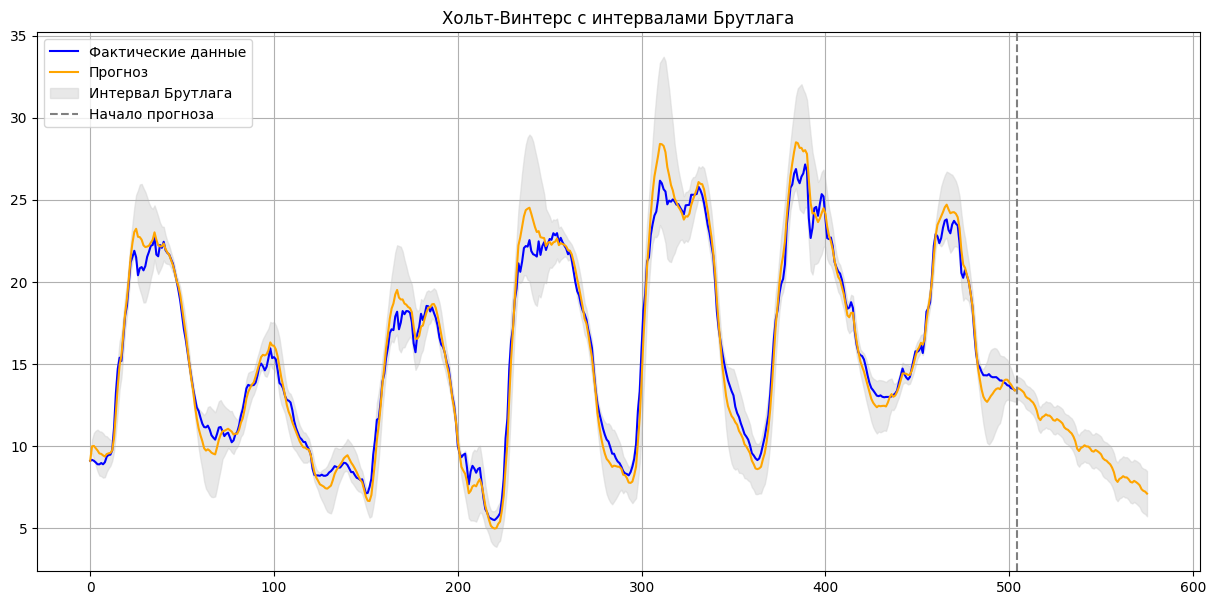

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(range(len(series)), series.values, label="Фактические данные", color='blue')
plt.plot(range(len(model.result)), model.result, label="Прогноз", color='orange')
plt.fill_between(range(len(model.result)), model.LowerBond, model.UpperBond, color="lightgrey", alpha=0.5,
                 label="Интервал Брутлага")
plt.axvline(x=len(series), color='gray', linestyle='--', label="Начало прогноза")
plt.title("Хольт-Винтерс с интервалами Брутлага")
plt.legend()
plt.grid(True)
plt.show()
